# Tunisia -Social Distancing AI using Python, Deep Learning and Computer Vision
In the fight against the COVID-19, social distancing has proven to be a very effective measure to slow down the spread of the disease. People are asked to limit their interactions with each other, reducing the chances of the virus being spread with physical or close contact.

# I Model-YOLOv3:

To ensure social distancing protocol in public places and workplace, I have developed social distancing detection tool that can monitor if people are keeping a safe distance from each other by analyzing real time video streams from the camera. For example: People at workplaces, factories, shops we can integrate this tool to their security camera systems and can monitor wether people are keeping a safe distance from each other or not.

This tool has following features:

    Detect humans in the frame with yolov3.
    Calculates the distance between every human who is detected in the frame.
    Shows how many people are at High, Low and Not at risk.
## Implementation Details:
#### Camera Prespective Transformation or Camera Calibration:

As the input video may be taken from an arbitrary perspective view, the first step is to transform perspective of view to a bird’s-eye (top-down) view. As the input frames are monocular (taken from a single camera), the simplest transformation method involves selecting four points in the perspective view which define ROI where we want to monitor social distancing and mapping them to the corners of a rectangle in the bird’s-eye view. Also these points should form parallel lines in real world if seen from above(birds eye view). This assumes that every person is standing on the same flat ground plane. This top view or bird eye view has the property that points are distributed uniformally horizontally and vertically(scale for horizontal and vertical direction will be different).From this mapping, we can derive a transformation that can be applied to the entire perspective image.    

# Detection:

The second step to detect pedestrians and draw a bounding box around each pedestrian. For simplicity, i am using an open-source pedestrian detection network based on the Yolo v3 architecture. To clean up the output bounding boxes, we apply minimal post-processing such as non-max suppression (NMS) and various rule-based heuristics, so as to minimize the risk of overfitting.
# Distance Calculation:

Now we have bounding box for each person in the frame. We need to estimate person location in frame. i.e we can take bottom center point of bounding box as person location in frame.

Then we estimate (x,y) location in bird’s eye view by applying transformation to the bottom center point of each person’s bounding box, resulting in their position in the bird’s eye view.

Last step is to compute the bird’s eye view distance between every pair of people and scale the distances by the scaling factor in horizontal and vertical direction estimated from calibration.

# Code Flow:
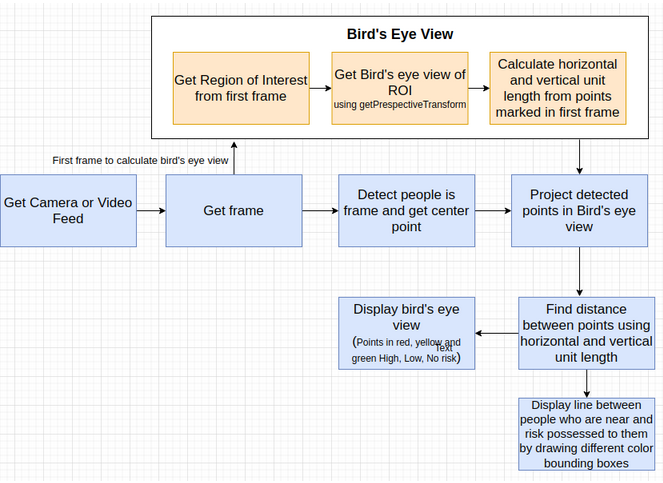


In [1]:
# imports
import cv2
import numpy as np

# Function to calculate bottom center for all bounding boxes and transform prespective for all points.
def get_transformed_points(boxes, prespective_transform):
    
    bottom_points = []
    for box in boxes:
        pnts = np.array([[[int(box[0]+(box[2]*0.5)),int(box[1]+box[3])]]] , dtype="float32")
        #pnts = np.array([[[int(box[0]+(box[2]*0.5)),int(box[1]+(box[3]*0.5))]]] , dtype="float32")
        bd_pnt = cv2.perspectiveTransform(pnts, prespective_transform)[0][0]
        pnt = [int(bd_pnt[0]), int(bd_pnt[1])]
        bottom_points.append(pnt)
        
    return bottom_points

# Function calculates distance between two points(humans). distance_w, distance_h represents number
# of pixels in 180cm length horizontally and vertically. We calculate horizontal and vertical
# distance in pixels for two points and get ratio in terms of 180 cm distance using distance_w, distance_h.
# Then we calculate how much cm distance is horizontally and vertically and then using pythagoras
# we calculate distance between points in terms of cm. 
def cal_dis(p1, p2, distance_w, distance_h):
    
    h = abs(p2[1]-p1[1])
    w = abs(p2[0]-p1[0])
    
    dis_w = float((w/distance_w)*180)
    dis_h = float((h/distance_h)*180)
    
    return int(np.sqrt(((dis_h)**2) + ((dis_w)**2)))

# Function calculates distance between all pairs and calculates closeness ratio.
def get_distances(boxes1, bottom_points, distance_w, distance_h):
    
    distance_mat = []
    bxs = []
    
    for i in range(len(bottom_points)):
        for j in range(len(bottom_points)):
            if i != j:
                dist = cal_dis(bottom_points[i], bottom_points[j], distance_w, distance_h)
                #dist = int((dis*180)/distance)
                if dist <= 150:
                    closeness = 0
                    distance_mat.append([bottom_points[i], bottom_points[j], closeness])
                    bxs.append([boxes1[i], boxes1[j], closeness])
                elif dist > 150 and dist <=180:
                    closeness = 1
                    distance_mat.append([bottom_points[i], bottom_points[j], closeness])
                    bxs.append([boxes1[i], boxes1[j], closeness])       
                else:
                    closeness = 2
                    distance_mat.append([bottom_points[i], bottom_points[j], closeness])
                    bxs.append([boxes1[i], boxes1[j], closeness])
                
    return distance_mat, bxs
 
# Function gives scale for birds eye view               
def get_scale(W, H):
    
    dis_w = 400
    dis_h = 600
    
    return float(dis_w/W),float(dis_h/H)
    
# Function gives count for humans at high risk, low risk and no risk    
def get_count(distances_mat):

    r = []
    g = []
    y = []
    
    for i in range(len(distances_mat)):

        if distances_mat[i][2] == 0:
            if (distances_mat[i][0] not in r) and (distances_mat[i][0] not in g) and (distances_mat[i][0] not in y):
                r.append(distances_mat[i][0])
            if (distances_mat[i][1] not in r) and (distances_mat[i][1] not in g) and (distances_mat[i][1] not in y):
                r.append(distances_mat[i][1])
                
    for i in range(len(distances_mat)):

        if distances_mat[i][2] == 1:
            if (distances_mat[i][0] not in r) and (distances_mat[i][0] not in g) and (distances_mat[i][0] not in y):
                y.append(distances_mat[i][0])
            if (distances_mat[i][1] not in r) and (distances_mat[i][1] not in g) and (distances_mat[i][1] not in y):
                y.append(distances_mat[i][1])
        
    for i in range(len(distances_mat)):
    
        if distances_mat[i][2] == 2:
            if (distances_mat[i][0] not in r) and (distances_mat[i][0] not in g) and (distances_mat[i][0] not in y):
                g.append(distances_mat[i][0])
            if (distances_mat[i][1] not in r) and (distances_mat[i][1] not in g) and (distances_mat[i][1] not in y):
                g.append(distances_mat[i][1])
   
    return (len(r),len(y),len(g))

In [2]:
# imports
import cv2
import numpy as np

# Function to draw Bird Eye View for region of interest(ROI). Red, Yellow, Green points represents risk to human. 
# Red: High Risk
# Yellow: Low Risk
# Green: No Risk
def bird_eye_view(frame, distances_mat, bottom_points, scale_w, scale_h, risk_count):
    h = frame.shape[0]
    w = frame.shape[1]

    red = (0, 0, 255)
    green = (0, 255, 0)
    yellow = (0, 255, 255)
    white = (200, 200, 200)

    blank_image = np.zeros((int(h * scale_h), int(w * scale_w), 3), np.uint8)
    blank_image[:] = white
    warped_pts = []
    r = []
    g = []
    y = []
    for i in range(len(distances_mat)):

        if distances_mat[i][2] == 0:
            if (distances_mat[i][0] not in r) and (distances_mat[i][0] not in g) and (distances_mat[i][0] not in y):
                r.append(distances_mat[i][0])
            if (distances_mat[i][1] not in r) and (distances_mat[i][1] not in g) and (distances_mat[i][1] not in y):
                r.append(distances_mat[i][1])

            blank_image = cv2.line(blank_image, (int(distances_mat[i][0][0] * scale_w), int(distances_mat[i][0][1] * scale_h)), (int(distances_mat[i][1][0] * scale_w), int(distances_mat[i][1][1]* scale_h)), red, 2)
            
    for i in range(len(distances_mat)):
                
        if distances_mat[i][2] == 1:
            if (distances_mat[i][0] not in r) and (distances_mat[i][0] not in g) and (distances_mat[i][0] not in y):
                y.append(distances_mat[i][0])
            if (distances_mat[i][1] not in r) and (distances_mat[i][1] not in g) and (distances_mat[i][1] not in y):
                y.append(distances_mat[i][1])
        
            blank_image = cv2.line(blank_image, (int(distances_mat[i][0][0] * scale_w), int(distances_mat[i][0][1] * scale_h)), (int(distances_mat[i][1][0] * scale_w), int(distances_mat[i][1][1]* scale_h)), yellow, 2)
            
    for i in range(len(distances_mat)):
        
        if distances_mat[i][2] == 2:
            if (distances_mat[i][0] not in r) and (distances_mat[i][0] not in g) and (distances_mat[i][0] not in y):
                g.append(distances_mat[i][0])
            if (distances_mat[i][1] not in r) and (distances_mat[i][1] not in g) and (distances_mat[i][1] not in y):
                g.append(distances_mat[i][1])
    
    for i in bottom_points:
        blank_image = cv2.circle(blank_image, (int(i[0]  * scale_w), int(i[1] * scale_h)), 5, green, 10)
    for i in y:
        blank_image = cv2.circle(blank_image, (int(i[0]  * scale_w), int(i[1] * scale_h)), 5, yellow, 10)
    for i in r:
        blank_image = cv2.circle(blank_image, (int(i[0]  * scale_w), int(i[1] * scale_h)), 5, red, 10)
        
    #pad = np.full((100,blank_image.shape[1],3), [110, 110, 100], dtype=np.uint8)
    #cv2.putText(pad, "-- HIGH RISK : " + str(risk_count[0]) + " people", (50, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    #cv2.putText(pad, "-- LOW RISK : " + str(risk_count[1]) + " people", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
    #cv2.putText(pad, "-- SAFE : " + str(risk_count[2]) + " people", (50,  80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    #blank_image = np.vstack((blank_image,pad))   
        
    return blank_image
    
# Function to draw bounding boxes according to risk factor for humans in a frame and draw lines between
# boxes according to risk factor between two humans.
# Red: High Risk
# Yellow: Low Risk
# Green: No Risk 
def social_distancing_view(frame, distances_mat, boxes, risk_count):
    
    red = (0, 0, 255)
    green = (0, 255, 0)
    yellow = (0, 255, 255)
    
    for i in range(len(boxes)):

        x,y,w,h = boxes[i][:]
        frame = cv2.rectangle(frame,(x,y),(x+w,y+h),green,2)
                           
    for i in range(len(distances_mat)):

        per1 = distances_mat[i][0]
        per2 = distances_mat[i][1]
        closeness = distances_mat[i][2]
        
        if closeness == 1:
            x,y,w,h = per1[:]
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),yellow,2)
                
            x1,y1,w1,h1 = per2[:]
            frame = cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),yellow,2)
                
            frame = cv2.line(frame, (int(x+w/2), int(y+h/2)), (int(x1+w1/2), int(y1+h1/2)),yellow, 2) 
            
    for i in range(len(distances_mat)):

        per1 = distances_mat[i][0]
        per2 = distances_mat[i][1]
        closeness = distances_mat[i][2]
        
        if closeness == 0:
            x,y,w,h = per1[:]
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),red,2)
                
            x1,y1,w1,h1 = per2[:]
            frame = cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),red,2)
                
            frame = cv2.line(frame, (int(x+w/2), int(y+h/2)), (int(x1+w1/2), int(y1+h1/2)),red, 2)
            
    pad = np.full((140,frame.shape[1],3), [110, 110, 100], dtype=np.uint8)
    cv2.putText(pad, "Bounding box shows the level of risk to the person.", (50, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (100, 100, 0), 2)
    cv2.putText(pad, "-- HIGH RISK : " + str(risk_count[0]) + " people", (50, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
    cv2.putText(pad, "-- LOW RISK : " + str(risk_count[1]) + " people", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 1)
    cv2.putText(pad, "-- SAFE : " + str(risk_count[2]) + " people", (50,  100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
    frame = np.vstack((frame,pad))
            
    return frame

In [3]:
'''Calculates Region of Interest(ROI) by receiving points from mouse event and transform prespective so that
we can have top view of scene or ROI. This top view or bird eye view has the property that points are
distributed uniformally horizontally and vertically(scale for horizontal and vertical direction will be
 different). So for bird eye view points are equally distributed, which was not case for normal view.
YOLO V3 is used to detect humans in frame and by calculating bottom center point of bounding boxe around humans, 
we transform those points to bird eye view. And then calculates risk factor by calculating distance between
points and then drawing birds eye view and drawing bounding boxes and distance lines between boxes on frame.
'''

# imports
import cv2
import numpy as np
import time
import argparse



confid = 0.5
thresh = 0.5
mouse_pts = []


# Function to get points for Region of Interest(ROI) and distance scale. It will take 8 points on first frame using mouse click    
# event.First four points will define ROI where we want to moniter social distancing. Also these points should form parallel  
# lines in real world if seen from above(birds eye view). Next 3 points will define 6 feet(unit length) distance in     
# horizontal and vertical direction and those should form parallel lines with ROI. Unit length we can take based on choice.
# Points should pe in pre-defined order - bottom-left, bottom-right, top-right, top-left, point 5 and 6 should form     
# horizontal line and point 5 and 7 should form verticle line. Horizontal and vertical scale will be different. 

# Function will be called on mouse events                                                          

def get_mouse_points(event, x, y, flags, param):

    global mouse_pts
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(mouse_pts) < 4:
            cv2.circle(image, (x, y), 5, (0, 0, 255), 10)
        else:
            cv2.circle(image, (x, y), 5, (255, 0, 0), 10)
            
        if len(mouse_pts) >= 1 and len(mouse_pts) <= 3:
            cv2.line(image, (x, y), (mouse_pts[len(mouse_pts)-1][0], mouse_pts[len(mouse_pts)-1][1]), (70, 70, 70), 2)
            if len(mouse_pts) == 3:
                cv2.line(image, (x, y), (mouse_pts[0][0], mouse_pts[0][1]), (70, 70, 70), 2)
        
        if "mouse_pts" not in globals():
            mouse_pts = []
        mouse_pts.append((x, y))
        #print("Point detected")
        #print(mouse_pts)
        


def calculate_social_distancing(vid_path, net, output_dir, output_vid, ln1):
    
    count = 0
    vs = cv2.VideoCapture(vid_path)    
    # Get video height, width and fps
    height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = int(vs.get(cv2.CAP_PROP_FPS))
    
    # Set scale for birds eye view
    # Bird's eye view will only show ROI
    scale_w, scale_h = get_scale(width, height)

    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    output_movie = cv2.VideoWriter(output_vid+"distancing.avi", fourcc, fps, (width, height))
    bird_movie = cv2.VideoWriter(output_vid+"bird_eye_view.avi", fourcc, fps, (int(width * scale_w), int(height * scale_h)))
        
    points = []
    global image
    
    while True:

        (grabbed, frame) = vs.read()

        if not grabbed:
            print('here')
            break
            
        (H, W) = frame.shape[:2]
        
        # first frame will be used to draw ROI and horizontal and vertical 180 cm distance(unit length in both directions)
        if count == 0:
            while True:
                image = frame
                cv2.imshow("image", image)
                cv2.waitKey(1)
                if len(mouse_pts) == 8:
                    cv2.destroyWindow("image")
                    break
               
            points = mouse_pts      
                 
        # Using first 4 points or coordinates for perspective transformation. The region marked by these 4 points are 
        # considered ROI. This polygon shaped ROI is then warped into a rectangle which becomes the bird eye view. 
        # This bird eye view then has the property property that points are distributed uniformally horizontally and 
        # vertically(scale for horizontal and vertical direction will be different). So for bird eye view points are 
        # equally distributed, which was not case for normal view.
        src = np.float32(np.array(points[:4]))
        dst = np.float32([[0, H], [W, H], [W, 0], [0, 0]])
        prespective_transform = cv2.getPerspectiveTransform(src, dst)

        # using next 3 points for horizontal and vertical unit length(in this case 180 cm)
        pts = np.float32(np.array([points[4:7]]))
        warped_pt = cv2.perspectiveTransform(pts, prespective_transform)[0]
        
        # since bird eye view has property that all points are equidistant in horizontal and vertical direction.
        # distance_w and distance_h will give us 180 cm distance in both horizontal and vertical directions
        # (how many pixels will be there in 180cm length in horizontal and vertical direction of birds eye view),
        # which we can use to calculate distance between two humans in transformed view or bird eye view
        distance_w = np.sqrt((warped_pt[0][0] - warped_pt[1][0]) ** 2 + (warped_pt[0][1] - warped_pt[1][1]) ** 2)
        distance_h = np.sqrt((warped_pt[0][0] - warped_pt[2][0]) ** 2 + (warped_pt[0][1] - warped_pt[2][1]) ** 2)
        pnts = np.array(points[:4], np.int32)
        cv2.polylines(frame, [pnts], True, (70, 70, 70), thickness=2)
    
    ####################################################################################
    
        # YOLO v3
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        start = time.time()
        layerOutputs = net.forward(ln1)
        end = time.time()
        boxes = []
        confidences = []
        classIDs = []   
    
        for output in layerOutputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                # detecting humans in frame
                if classID == 0:

                    if confidence > confid:

                        box = detection[0:4] * np.array([W, H, W, H])
                        (centerX, centerY, width, height) = box.astype("int")

                        x = int(centerX - (width / 2))
                        y = int(centerY - (height / 2))

                        boxes.append([x, y, int(width), int(height)])
                        confidences.append(float(confidence))
                        classIDs.append(classID)
                    
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, confid, thresh)
        font = cv2.FONT_HERSHEY_PLAIN
        boxes1 = []
        for i in range(len(boxes)):
            if i in idxs:
                boxes1.append(boxes[i])
                x,y,w,h = boxes[i]
                
        if len(boxes1) == 0:
            count = count + 1
            continue
            
        # Here we will be using bottom center point of bounding box for all boxes and will transform all those
        # bottom center points to bird eye view
        person_points = get_transformed_points(boxes1, prespective_transform)
        
        # Here we will calculate distance between transformed points(humans)
        distances_mat, bxs_mat = get_distances(boxes1, person_points, distance_w, distance_h)
        risk_count = get_count(distances_mat)
    
        frame1 = np.copy(frame)
        
        # Draw bird eye view and frame with bouding boxes around humans according to risk factor    
        bird_image = bird_eye_view(frame, distances_mat, person_points, scale_w, scale_h, risk_count)
        img = social_distancing_view(frame1, bxs_mat, boxes1, risk_count)
        
        # Show/write image and videos
        if count != 0:
            output_movie.write(img)
            bird_movie.write(bird_image)
    
            cv2.imshow('Bird Eye View', bird_image)
            cv2.imwrite(output_dir+"frame%d.jpg" % count, img)
            cv2.imwrite(output_dir+"bird_eye_view/frame%d.jpg" % count, bird_image)
    
        count = count + 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
     
    vs.release()
    cv2.destroyAllWindows() 
        

if __name__== "__main__":

    # Receives arguements specified by user
    
    #parser = argparse.ArgumentParser()
    
    #parser.add_argument('-v', '--video_path', action='store', dest='video_path', default='C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Social-Distancing-Detector-master/Social-Distancing-Detector-master/videos/test_vedio.mp4' ,                   help='Path for input video')                   
    #parser.add_argument('-o', '--output_dir', action='store', dest='output_dir', default='./output/' ,help='Path for Output images')
    
    #parser.add_argument('-O', '--output_vid', action='store', dest='output_vid', default='./output_vid/' ,help='Path for Output videos')

    #parser.add_argument('-m', '--model', action='store', dest='model', default='./models/',help='Path for models directory')
                    
    #parser.add_argument('-u', '--uop', action='store', dest='uop', default='NO',help='Use open pose or not (YES/NO)')
                    
    #values = parser.parse_args()

    #model_path = values.model
    #if model_path[len(model_path) - 1] != '/':
     #   model_path = model_path + '/'
        
    #output_dir = values.output_dir
    #if output_dir[len(output_dir) - 1] != '/':
     #   output_dir = output_dir + '/'
    
    #output_vid = values.output_vid
    #if output_vid[len(output_vid) - 1] != '/':
       # output_vid = output_vid + '/'
   
    # load Yolov3 weights
    
    weightsPath =  "C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Social-Distancing-Detector-master/Social-Distancing-Detector-master/yolov3.weights"
    configPath =  "C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Social-Distancing-Detector-master/Social-Distancing-Detector-master/yolov3.cfg"

    net_yl = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    ln = net_yl.getLayerNames()
    ln1 = [ln[i[0] - 1] for i in net_yl.getUnconnectedOutLayers()]

    # set mouse callback 

    cv2.namedWindow("image")
    cv2.setMouseCallback("image", get_mouse_points)
    np.random.seed(42)
    video_path='C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Social-Distancing-Detector-master/Social-Distancing-Detector-master/videos/test_video.mp4'
    output_dir='C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Social-Distancing-Detector-master/Social-Distancing-Detector-master/videos/'
    output_vid='C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Social-Distancing-Detector-master/Social-Distancing-Detector-master/videos/'
    calculate_social_distancing(video_path, net_yl, output_dir, output_vid, ln1)


here


In [4]:
# https://blog.usejournal.com/social-distancing-ai-using-python-deep-learning-c26b20c9aa4c
# https://github.com/deepak112/Social-Distancing-AI/blob/master/plot.py
#2 https://github.com/vigneshgig/Social-Distancing-Detection/blob/master/predictor.py
#2 https://medium.com/@vigneshgig/social-distancing-detection-a1dd758125f8
#3 https://www.analyticsvidhya.com/blog/2020/05/social-distancing-detection-tool-deep-learning/

In [5]:
#Before runnig this file make sure you have Pretrained model and classes folder
#you can get all thing via my github link i will mention below
#It will depend on CPU performance if your cpu performance is good the video will process fast
#i have not good cpu performacnce to that why its processing quite low
import cv2
import datetime
import imutils
from itertools import combinations
import math
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np


class CentroidTracker:
    def __init__(self, maxDisappeared=50, maxDistance=50):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.bbox = OrderedDict()  # CHANGE

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared

        # store the maximum distance between centroids to associate
        # an object -- if the distance is larger than this maximum
        # distance we'll start to mark the object as "disappeared"
        self.maxDistance = maxDistance

    def register(self, centroid, inputRect):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.bbox[self.nextObjectID] = inputRect  # CHANGE
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
        del self.bbox[objectID]  # CHANGE

    def update(self, rects):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(rects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1

                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            # return early as there are no centroids or tracking info
            # to update
            # return self.objects
            return self.bbox

        # initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")
        inputRects = []
        # loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)
            inputRects.append(rects[i])  # CHANGE

        # if we are currently not tracking any objects take the input
        # centroids and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i], inputRects[i])  # CHANGE

        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value as at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()

            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()

            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                if row in usedRows or col in usedCols:
                    continue

                # if the distance between centroids is greater than
                # the maximum distance, do not associate the two
                # centroids to the same object
                if D[row, col] > self.maxDistance:
                    continue

                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.bbox[objectID] = inputRects[col]  # CHANGE
                self.disappeared[objectID] = 0

                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)

            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            # in the event that the number of object centroids is
            # equal or greater than the number of input centroids
            # we need to check and see if some of these objects have
            # potentially disappeared
            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1

                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)

            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col], inputRects[col])

        # return the set of trackable objects
        # return self.objects
        return self.bbox
#THE model and prototype files are here
protopath = "C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Computer-Vision-master/Social_distancing/MobileNetSSD_deploy.prototxt"
modelpath = "C:/Users/rzouga/Downloads/Github/CNN_CV/Computer-Vision-master/Computer-Vision-master/Social_distancing/MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)

#mention num of classes here
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker(maxDisappeared=40, maxDistance=50)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))
#Pass the video link here

def main():
    cap = cv2.VideoCapture(0)

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    while True:
        ret, frame = cap.read()
        frame = imutils.resize(frame, width=600)
        total_frames = total_frames + 1

        (H, W) = frame.shape[:2]

        blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

        detector.setInput(blob)
        person_detections = detector.forward()
        rects = []
        for i in np.arange(0, person_detections.shape[2]):
            confidence = person_detections[0, 0, i, 2]
            if confidence > 0.5:
                idx = int(person_detections[0, 0, i, 1])

                if CLASSES[idx] != "person":
                    continue

                person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                (startX, startY, endX, endY) = person_box.astype("int")
                rects.append(person_box)

        boundingboxes = np.array(rects)
        boundingboxes = boundingboxes.astype(int)
        rects = non_max_suppression_fast(boundingboxes, 0.3)
        centroid_dict = dict()
        objects = tracker.update(rects)
        for (objectId, bbox) in objects.items():
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            cX = int((x1 + x2) / 2.0)
            cY = int((y1 + y2) / 2.0)


            centroid_dict[objectId] = (cX, cY, x1, y1, x2, y2)

            # text = "ID: {}".format(objectId)
            # cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        red_zone_list = []
        for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
            dx, dy = p1[0] - p2[0], p1[1] - p2[1]
            distance = math.sqrt(dx * dx + dy * dy)
            if distance < 75.0:
                if id1 not in red_zone_list:
                    red_zone_list.append(id1)
                if id2 not in red_zone_list:
                    red_zone_list.append(id2)

        for id, box in centroid_dict.items():
            if id in red_zone_list:
                cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 0, 255), 2)
            else:
                cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2)


        fps_end_time = datetime.datetime.now()
        time_diff = fps_end_time - fps_start_time
        if time_diff.seconds == 0:
            fps = 0.0
        else:
            fps = (total_frames / time_diff.seconds)

        fps_text = "FPS: {:.2f}".format(fps)

        cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

        cv2.imshow("Social_Distancing", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break

    cv2.destroyAllWindows()

main()

KeyboardInterrupt: 